# Exogenous Process modeling 

# UPDATE
## ETH price stochastic process

1. Acquire time series of Eth/USD data from Big Query (see [BigQueryRaiData](BigQueryRaiData.ipynb)
2. Fit a parametric distribution to the price of ETH, gamma + Kalman fit (prediction) resulting in a distribution $F^p_{ETH}(t; \mu_{ETH})$ and fitted parameters $\mu_{ETH}$.

In [120]:
# import libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import pymc3 as pm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib inline

## Data preprocessing

In [129]:
# import data
data = pd.read_csv('data/RaiLiveGraphData.csv')
data = data[['blockNumber','Eth_price']]
data.head(5)

,blockNumber,Eth_price
0,11857308,1803.656430
1,11860793,1803.656430
2,11861399,1763.974936
3,11861474,1763.974936
4,11862329,1803.891149


In [130]:
len(data)

1258

In [ ]:
data.head()

In [131]:
# sort by date from earliest to latest
data_sorted = data.sort_values(by='blockNumber')

In [132]:
# split into training and test data. 
train, test= np.split(data_sorted, [int(.9 *len(data_sorted))])

In [134]:
train.tail()

,blockNumber,Eth_price
1127,12241200,2413.140000
1128,12241996,2431.063966
1129,12242262,2419.970000
1130,12242385,2419.970000
1131,12242749,2420.380454


<AxesSubplot:title={'center':'Eth Live data'}, xlabel='blockNumber'>

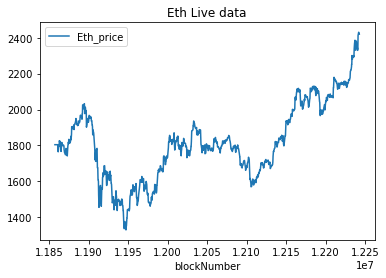

In [133]:
train.plot(x='blockNumber',y='Eth_price',title='Eth Live data')

## Kalman filter

Kalman filters are a lightweight algorithm often in an economic context for reducing noise in signals. The Kalman Filter is trained on a subset of the data, and then the parameters are passed into a prediction function for use in subsequent samples. As Kalman filters are one step predictors, at each time step, the filters is retrained and the system state and parameters are updated. 

This implemention was refined by Andrew Clark in a [recent paper](https://ideas.repec.org/p/rdg/emxxdp/em-dp2020-22.html) that used Kalman filters embedded into a cadCAD model for forecasting exchange rates.

In [149]:
import pandas as pd
import numpy as np
from scipy.stats import gamma

def kalman_filter(observations,initialValue,truthValues=None,plot=False,paramExport=False):
    '''
    Description:
    Function to create a Kalman Filter for smoothing currency timestamps in order to search for the
    intrinisic value.
    
    Parameters:
    observations: Array of observations, i.e. predicted secondary market prices.
    initialValue: Initial Starting value of filter
    truthValues: Array of truth values, i.e. GPS location or secondary market prices. Or can be left
    blank if none exist
    plot: If True, plot the observations, truth values and kalman filter.
    paramExport: If True, the parameters xhat,P,xhatminus,Pminus,K are returned to use in training.
    
    Example:
    xhat,P,xhatminus,Pminus,K = kalman_filter(observations=train.Close.values[0:-1],
                                              initialValue=train.Close.values[-1],paramExport=True)
    '''
    # intial parameters
    n_iter = len(observations)
    sz = (n_iter,) # size of array
    if isinstance(truthValues,np.ndarray):
        x = truthValues # truth value
    z = observations# observations (normal about x, sigma=0.1)

    Q = 1e-5 # process variance

    # allocate space for arrays
    xhat=np.zeros(sz)      # a posteri estimate of x
    P=np.zeros(sz)         # a posteri error estimate
    xhatminus=np.zeros(sz) # a priori estimate of x
    Pminus=np.zeros(sz)    # a priori error estimate
    K=np.zeros(sz)         # gain or blending factor

    R = 0.1**2 # estimate of measurement variance, change to see effect

    # intial guesses
    xhat[0] = initialValue
    P[0] = 1.0

    for k in range(1,n_iter):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]

    if plot==True:
        plt.figure()
        plt.plot(z,'k+',label='Actual data')
        plt.plot(xhat,'b-',label='a posteri estimate')
        if isinstance(truthValues,np.ndarray):
            plt.plot(x,color='g',label='truth value')
        plt.legend()
        plt.title('Kalman Filter Estimates', fontweight='bold')
        plt.xlabel('Iteration')
        plt.ylabel('USD')
        plt.show()

    if paramExport==True:
        return  xhat,P,xhatminus,Pminus,K

    else:

        return xhat

def kalman_filter_predict(xhat,P,xhatminus,Pminus,K,observations,truthValues=None,paramExport=False):
    '''
    Description:
    Function to predict a pre-trained Kalman Filter 1 step forward.
    
    Parameters:
    xhat: Trained Kalman filter values - array
    P: Trained Kalman variance - array
    xhatminus: Trained Kalman xhat delta - array
    Pminus: Trained Kalman variance delta - array
    K: Kalman gain - array
    observations: Array of observations, i.e. predicted secondary market prices.
    truthValues: Array of truth values, i.e. GPS location or secondary market prices. Or can be left
    blank if none exist
    paramExport: If True, the parameters xhat,P,xhatminus,Pminus,K are returned to use in next predicted step.
    
    Example:
    xhat,P,xhatminus,Pminus,K = kalman_filter_predict(xhatInput,PInput,
                                                      xhatminusInput,PminusInput,KInput,observation,
                                                       paramExport=True)
    '''
    # intial parameters
    if isinstance(truthValues,np.ndarray):
        x = truthValues # truth value
    z = observations# observations (normal about x, sigma=0.1)

    Q = 1e-5 # process variance

    R = 0.1**2 # estimate of measurement variance, change to see effect


    # time update
    xhatminus = np.append(xhatminus,xhat[-1])
    Pminus = np.append(Pminus,P[-1]+Q)

    # measurement update
    K = np.append(K,Pminus[-1]/( Pminus[-1]+R ))
    xhat = np.append(xhat,xhatminus[-1]+K[-1]*(z[-1]-xhatminus[-1]))
    P = np.append(P,(1-K[-1])*Pminus[-1])

    if paramExport==True:
        return  xhat,P,xhatminus,Pminus,K

    else:

        return xhat

## Process training

Fit the gamma distribution off of the training data.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.
/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


(array([  6.,  37.,  73., 151., 253., 221., 150.,  74.,  32.,   3.]),
 array([1795.75244285, 1798.06798964, 1800.38353644, 1802.69908324,
        1805.01463003, 1807.33017683, 1809.64572363, 1811.96127043,
        1814.27681722, 1816.59236402, 1818.90791082]),
 <BarContainer object of 10 artists>)

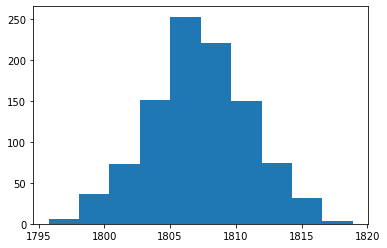

In [168]:
# timesteps = 24 * 365 # 24 hours a day * 365 days a year 
# # fit eth distribution
# fit_shape, fit_loc, fit_scale = stats.gamma.fit(train['ETH Price (OSM)'].values)
# sample = np.random.gamma(fit_shape, fit_scale, 100)[0]
# sample


model = pm.Model()

with model: 

    # alpha
    alpha = pm.Exponential('alpha', lam=2)

    # beta
    beta = pm.Exponential('beta', lam=.1)

    g = pm.Gamma('g', alpha=fit_alpha, beta=beta, observed=train['Eth_price'].values)

    trace = pm.sample(2000, return_inferencedata=True)
    
    
ppc_test = pm.sample_posterior_predictive(trace, model=model, samples=1000)
# Compute the point prediction by taking the mean
# and defining the category via a threshold.
p_test_pred = ppc_test["g"].mean(axis=1)
plt.hist(p_test_pred)

In [169]:
len(p_test_pred)

1000

(array([[ 0.,  2., 47., ...,  3.,  2.,  0.],
        [ 0.,  0., 48., ...,  3.,  1.,  0.],
        [ 0.,  3., 35., ..., 11.,  1.,  0.],
        ...,
        [ 0.,  5., 58., ...,  9.,  0.,  0.],
        [ 0.,  8., 43., ...,  6.,  0.,  0.],
        [ 0.,  5., 55., ...,  4.,  1.,  0.]]),
 array([1373.47621195, 1469.84411563, 1566.2120193 , 1662.57992298,
        1758.94782666, 1855.31573034, 1951.68363402, 2048.0515377 ,
        2144.41944138, 2240.78734506, 2337.15524874]),
 <a list of 1132 BarContainer objects>)

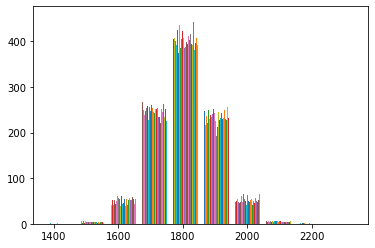

In [167]:
plt.hist(ppc_test["g"])

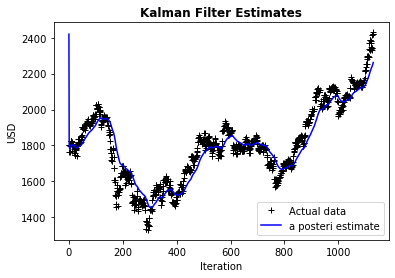

In [150]:
# train kalman
xhat,P,xhatminus,Pminus,K = kalman_filter(observations=train['Eth_price'].values[0:-1],
                                          initialValue=train['Eth_price'].values[-1],paramExport=True,plot=True)

In [ ]:
# # train kalman
# xhat,P,xhatminus,Pminus,K = kalman_filter(observations=samples[0:-1],
#                                           initialValue=samples[-1],paramExport=True,plot=True)

## Validation

To test how our generator is working, we will make 100 predictions and compare to the test data.

In [152]:
eth_values = []
filter_values = {'xhat':xhat,'P':P,
                 'xhatminus':xhatminus,'Pminus':Pminus,
                 'K':K}

for i in range(0,100):
    #sample = np.random.gamma(fit_shape, fit_scale, 1)[0]
    sample = p_test_pred[i]
    eth_values.append(sample)
    xhat,P,xhatminus,Pminus,K = kalman_filter_predict(filter_values['xhat'],
                                                  filter_values['P'],
                                                  filter_values['xhatminus'],
                                                  filter_values['Pminus'],
                                                  filter_values['K'],
                                                  eth_values,
                                                  paramExport=True)
    filter_values = {'xhat':xhat,'P':P,
                 'xhatminus':xhatminus,'Pminus':Pminus,
                 'K':K}
                                                                    

In [154]:
xhat[-100:]

array([1825.36349164, 1824.74254632, 1824.23072299, 1823.7544904 ,
       1823.19211778, 1822.72590702, 1822.06473974, 1821.60831875,
       1821.00448262, 1820.39454891, 1819.765477  , 1819.1403069 ,
       1818.71466981, 1818.31562147, 1818.05296742, 1817.72556504,
       1817.37353097, 1817.04498786, 1816.77826689, 1816.47897508,
       1816.1664419 , 1815.89146027, 1815.56913833, 1815.15094209,
       1814.71429018, 1814.5291828 , 1813.94559636, 1813.65727452,
       1813.44383394, 1813.05797997, 1812.78286705, 1812.6487197 ,
       1812.25714897, 1811.94053703, 1811.73064982, 1811.72631193,
       1811.71782944, 1811.64473367, 1811.3959082 , 1811.21180426,
       1811.00492999, 1810.77119131, 1810.63534071, 1810.41583267,
       1810.35683104, 1810.06571231, 1810.20703395, 1810.03030354,
       1809.80357417, 1809.77183143, 1809.71395042, 1809.62759918,
       1809.65779023, 1809.50739508, 1809.36782718, 1809.25622168,
       1809.0914258 , 1809.11047762, 1809.04729383, 1808.89280

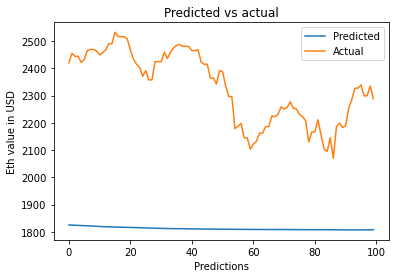

In [153]:
plt.plot(xhat[-100:], label = 'Predicted')
plt.plot(test[:100]['Eth_price'].values, label = 'Actual')
plt.xlabel('Predictions')
plt.ylabel('Eth value in USD')
# Set a title of the current axes.
plt.title('Predicted vs actual')
plt.legend()
# Display a figure.
plt.show()

## Generate data for simulation

In [ ]:
samples = np.random.gamma(fit_shape, fit_scale, 100)
# train kalman
xhat,P,xhatminus,Pminus,K = kalman_filter(observations=samples[0:-1],
                                          initialValue=samples[-1],paramExport=True,plot=True)

In [ ]:
eth_values = []
filter_values = {'xhat':xhat,'P':P,
                 'xhatminus':xhatminus,'Pminus':Pminus,
                 'K':K}

for i in range(0,timesteps+1):
    sample = np.random.gamma(fit_shape, fit_scale, 1)[0]
    eth_values.append(sample)
    xhat,P,xhatminus,Pminus,K = kalman_filter_predict(filter_values['xhat'],
                                                  filter_values['P'],
                                                  filter_values['xhatminus'],
                                                  filter_values['Pminus'],
                                                  filter_values['K'],
                                                  eth_values,
                                                  paramExport=True)
    filter_values = {'xhat':xhat,'P':P,
                 'xhatminus':xhatminus,'Pminus':Pminus,
                 'K':K}
                                                                    

In [ ]:
plt.hist(xhat[100:])
plt.title('Histogram of Eth Price IID Samples')

In [ ]:
plt.plot(xhat[100:])
plt.title('Predicted Eth Prices')

In [ ]:
timesteps

In [ ]:
eth_prices = pd.DataFrame(eth_values,columns=['Eth_price'])
eth_prices.head()

In [ ]:
# export data
eth_prices.to_csv('data/eth_prices.csv')

### Generate Monte Carlo runs

In [ ]:
def generate_eth_timeseries(xhat, P, xhatminus, Pminus, K):
    eth_values = []
    filter_values = {'xhat':xhat,'P':P,
                     'xhatminus':xhatminus,'Pminus':Pminus,
                     'K':K}

    for i in range(0,timesteps+1):
        sample = np.random.gamma(fit_shape, fit_scale, 1)[0]
        eth_values.append(sample)
        xhat,P,xhatminus,Pminus,K = kalman_filter_predict(filter_values['xhat'],
                                                      filter_values['P'],
                                                      filter_values['xhatminus'],
                                                      filter_values['Pminus'],
                                                      filter_values['K'],
                                                      eth_values,
                                                      paramExport=True)
        filter_values = {'xhat':xhat,'P':P,
                     'xhatminus':xhatminus,'Pminus':Pminus,
                     'K':K}

    return eth_values, xhat, P, xhatminus, Pminus, K

In [ ]:
monte_carlo_runs = 100

eth_values_mc = {}
for run in range(0, monte_carlo_runs):
    np.random.seed(seed=run)
    
    buffer_for_transcients = 100
    samples = np.random.gamma(fit_shape, fit_scale, timesteps + buffer_for_transcients)
    # train kalman
    xhat,P,xhatminus,Pminus,K = kalman_filter(observations=samples[0:-1],
                                              initialValue=samples[-1],paramExport=True,plot=False)
    
    # eth_values, _, _, _, _, _ = generate_eth_timeseries(xhat, P, xhatminus, Pminus, K)
    eth_values_mc[run] = xhat[buffer_for_transcients:]
    
eth_values, xhat, P, xhatminus, Pminus, K = generate_eth_timeseries(xhat, P, xhatminus, Pminus, K)

eth_values_mc_df = pd.DataFrame(eth_values_mc)
eth_values_mc_df.to_csv('data/eth_values_mc.csv')
eth_values_mc_df

## Implementation information
Below is an example of how to integrate these univariate time series datasets into the exogenous process section of a cadCAD model, assuming each timestep is an hour.


```
    
# partial_state_update_block.py
partial_state_update_block = {
    # Exogenous
    'Exogenous': {
        'policies': {
        },
        'variables': {
            'eth_price': eth_price_mech,
        }
    },
    
# exogenousProcesses.py


# import libraries
import pandas as pd

# import data
eth_prices = pd.read_csv('data/eth_prices.csv')

# mechanisms
def eth_price_mech(params, step, sL, s, _input):
    y = 'eth_price'
    timestep = s['timestep'] 
    x = eth_prices.Eth_price.values[timestep]
    return (y, x)

    
```

## Conclusion

In this notebook, we've read in hourly historical eth data from kaggle, defined functions for fitting and making predictions off of a gamma distribution, which is comminly used in for random walk calculations, and defined functions for de-noising kalman filter. We then validated the structure of these functions and predicted 100 timesteps for evaluation and demonstration purposes. Finally, we provided an overview of how to fit this code into cadCAD. Next steps could include:
* Refining the Kalman filter hyperparameters
* Refining the gamma prediction tuning parameter
* More thorough model validation
* Add seasonality

